# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os, glob
import cv2
%matplotlib inline

In [2]:
### Default values ###
gaussian_kernel      = 5
canny_low_threshold  = 60
canny_high_threshold = 150

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


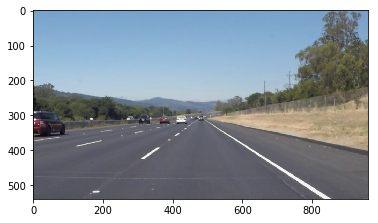

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg');
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [4]:
def display_images_UT(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

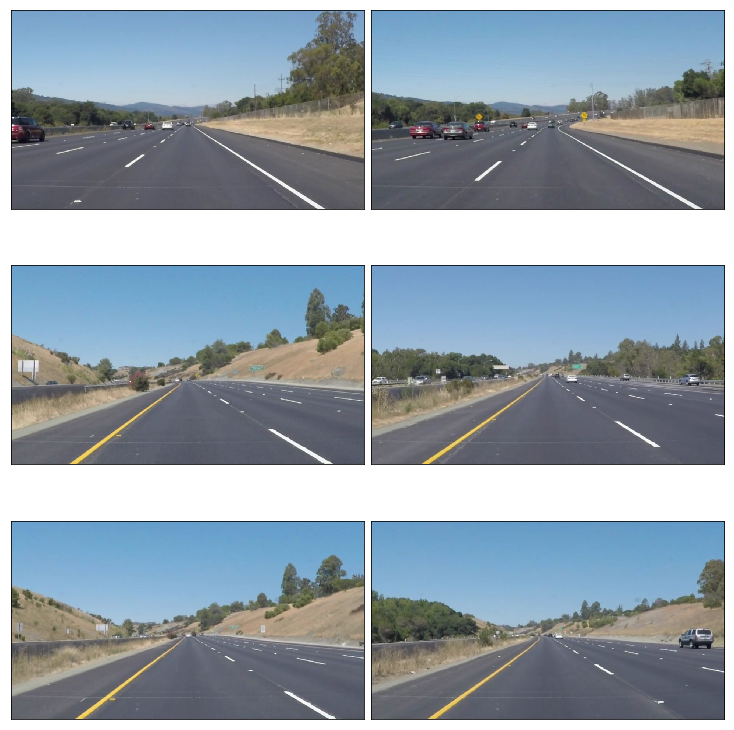

In [5]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

display_images_UT(test_images)

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def convert2hsv(image):
    """ Apply HSV transform"""
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel and kernel_size must be postivie and odd"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=20):
    x_size = img.shape[1]
    y_size = img.shape[0]
    lines_slope_intercept = np.zeros(shape=(len(lines),2))
    
    for index,line in enumerate(lines):        
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - x1 * slope
            lines_slope_intercept[index]=[slope,intercept]
    max_slope_line = lines_slope_intercept[lines_slope_intercept.argmax(axis=0)[0]]
    min_slope_line = lines_slope_intercept[lines_slope_intercept.argmin(axis=0)[0]]
    
    left_slopes = []
    left_intercepts = []
    right_slopes = []
    right_intercepts = []
    
    #Filtered out the Left and Right lines 
    for line in lines_slope_intercept:
        if abs(line[0] - max_slope_line[0]) < 0.15 and abs(line[1] - max_slope_line[1]) < (0.15 * x_size):
            left_slopes.append(line[0])
            left_intercepts.append(line[1])
        elif abs(line[0] - min_slope_line[0]) < 0.15 and abs(line[1] - min_slope_line[1]) < (0.15 * x_size):
            right_slopes.append(line[0])
            right_intercepts.append(line[1])
    
    # extrapolate lines to edges and center
    new_lines = np.zeros(shape=(1,2,4), dtype=np.int32)
    if len(left_slopes) > 0:
        left_line = [sum(left_slopes)/len(left_slopes),sum(left_intercepts)/len(left_intercepts)]
        left_bottom_x = (y_size - left_line[1])/left_line[0]
        left_top_x = (y_size*.575 - left_line[1])/left_line[0]
        if (left_bottom_x >= 0):
            new_lines[0][0] =[left_bottom_x,y_size,left_top_x,y_size*.575]
    if len(right_slopes) > 0:
        right_line = [sum(right_slopes)/len(right_slopes),sum(right_intercepts)/len(right_intercepts)]
        right_bottom_x = (y_size - right_line[1])/right_line[0]
        right_top_x = (y_size*.575 - right_line[1])/right_line[0]
        if (right_bottom_x <= x_size):
            new_lines[0][1]=[right_bottom_x,y_size,right_top_x,y_size*.575]
    for line in new_lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
    """
    return cv2.addWeighted(initial_img,α , img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

run your solution on all test_images and make copies into the test_images directory).

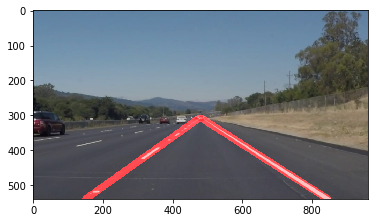

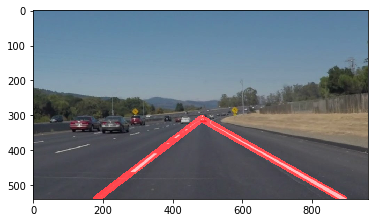

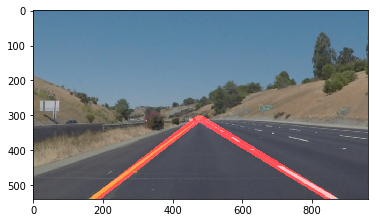

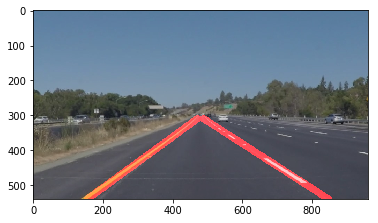

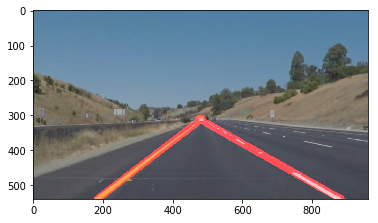

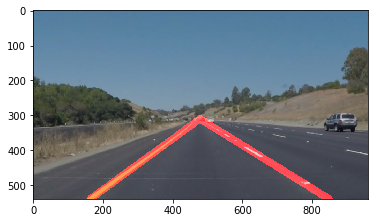

In [8]:
#reading in an image
for index, img in enumerate(os.listdir("test_images/")):
    image = mpimg.imread('test_images/' + img)
    
    # Convert RGB to grayscale
    gray_img = grayscale(image)    
    
    # Converting images to HSV scale to obtain good color discrimination
    hsv_img = convert2hsv(image)
    
      
    # define range of color in HSV
    #lower_yel = np.array([20,100,100]) #10,0,100
    #upper_yel = np.array([30,255,255]) #40,255,255
    #lower_wht = np.array([0,0,235])    #0,200,0
    #upper_wht = np.array([255,255,255])#255,255,255

    lower_yel = np.array([10,0,100]) #10,0,100
    upper_yel = np.array([40,255,255]) #40,255,255
    lower_wht = np.array([0,200,0])    #0,200,0
    upper_wht = np.array([255,255,255])#255,255,255

    
    
    #  We use a color mask to an image to remove all colors except for the ones we are interested
    # We use inRange function where input is an image and a range of the colors we want to create a mask for.
    # Isolate yellow in HSV to produce a yellow mask
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    # Isolate white in HSV to produce a white mask
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    
    # Bitwise-or mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)
    
    # At an edge/line,the pixel intensity changes from 0 to 255 which we want to detect.
    # So task is to smooth the edges to avoid noise
    # bigger kernel_size means more blurred image, so ideally we should go with that but process time is more :(
    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    #display_images_UT(blurred_img)

    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    roi_img = region_of_interest(edges_img, vertices)
    
    #display_images_UT(roi_img)

    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70     # Only those lines are returned that get enough votes (> threshold).
    hough_min_line_len = 70  # Minimum line length. Line segments shorter than that are rejected.
    hough_max_line_gap = 250 # Maximum allowed gap between points on the same line to join them.
    hough_img = hough_lines(roi_img,hough_rho,hough_theta,hough_threshold,hough_min_line_len,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
  
    fig = plt.figure(figsize=(6,10))
    plt.imshow(result, cmap="gray")  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
     
    # Convert RGB to grayscale
    gray_img = grayscale(image)    
    
    # Converting images to HSV scale to obtain good color discrimination
    hsv_img = convert2hsv(image)
    
      
    # define range of color in HSV
    lower_yel = np.array([10,0,100]) #10,0,100
    upper_yel = np.array([40,255,255]) #40,255,255
    lower_wht = np.array([0,200,0])    #0,200,0
    upper_wht = np.array([255,255,255])#255,255,255

    
    #  We use a color mask to an image to remove all colors except for the ones we are interested
    # We use inRange function where input is an image and a range of the colors we want to create a mask for.
    # Isolate yellow in HSV to produce a yellow mask
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    # Isolate white in HSV to produce a white mask
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    
    # Bitwise-or mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)
    
    # At an edge/line,the pixel intensity changes from 0 to 255 which we want to detect.
    # So task is to smooth the edges to avoid noise
    # bigger kernel_size means more blurred image, so ideally we should go with that but process time is more :(
    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
   # display_images_UT(blurred_img)

    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    roi_img = region_of_interest(edges_img, vertices)
    
    #display_images_UT(blurred_img)

    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70     # Only those lines are returned that get enough votes (> threshold).
    hough_min_line_len = 70  # Minimum line length. Line segments shorter than that are rejected.
    hough_max_line_gap = 250 # Maximum allowed gap between points on the same line to join them.
    hough_img = hough_lines(roi_img,hough_rho,hough_theta,hough_threshold,hough_min_line_len,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'output_videos/white.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_videos/white.mp4
[MoviePy] Writing video output_videos/white.mp4


100%|█████████▉| 221/222 [00:07<00:00, 29.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/white.mp4 

CPU times: user 44.6 s, sys: 272 ms, total: 44.9 s
Wall time: 7.71 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'output_videos/yellow.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video output_videos/yellow.mp4
[MoviePy] Writing video output_videos/yellow.mp4


100%|█████████▉| 681/682 [00:24<00:00, 27.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/yellow.mp4 

CPU times: user 2min 27s, sys: 660 ms, total: 2min 27s
Wall time: 24.8 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

**Reflections**: 
The algorithem so far detects the straight lanes successfully in images and in video occesionally there is jerky lines.
Need to spend more time to fix the problems or failures in identifying curve lanes by loooking into the details about poly fitting,transformation to find balanced ROI as current implementation is based of center of image.

Areas of improvement:
Modify the image processing code to update settings like (guassian blur kernel, hough thresholds, etc.) in order to get a better output.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_output = 'output_videos/extra.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video output_videos/extra.mp4
[MoviePy] Writing video output_videos/extra.mp4


100%|██████████| 251/251 [00:12<00:00, 19.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/extra.mp4 

CPU times: user 1min, sys: 332 ms, total: 1min 1s
Wall time: 12.5 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))